# Set-Up

## Installations and Imports

In [1]:
# !pip uninstall tetridiv --yes
# !pip install ..

In [2]:
# To run this notebook, first install gmsh by running the following terminal command:
# sudo apt install python3-gmsh
# Next, install the following using pip:
# !pip install pygmsh meshio pyvista vtk numpyencoder

In [3]:
import pygmsh
import meshio
import os
import json
import tetridiv
import pyvista
import numpy as np
from numpyencoder import NumpyEncoder
import dolfinx
import mpi4py
import vtk
from visualisation_helpers import plot_mesh, create_pyvista_grid

## Display Options

In [4]:
show_args = {}
# For interactive plots, uncomment the following line:
# show_args = {'jupyter_backend': 'panel', 'return_viewer': True}

## `dolfinx` helper methods

In [5]:
# vtk_idx = {'hexahedron': vtk.VTK_HEXAHEDRON, 'tetra': vtk.VTK_TETRA,
#            'quad': vtk.VTK_QUAD, 'triangle': vtk.VTK_TRIANGLE}
def unpack_dolfinx_mesh(mesh):
    V = dolfinx.fem.FunctionSpace(mesh, ("CG", 1))
    vtk_mesh = dolfinx.plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(*vtk_mesh)
    points, cells = grid.points, grid.cells_dict[vtk_mesh[1][0]]
    return points, cells

In [6]:
# See http://gmsh.info//doc/texinfo/gmsh.html#MSH-file-format
gmsh_idx = {'hexahedron': 5, 'tetra': 4, 'quad': 3, 'triangle': 2}
def create_dolfinx_mesh(mesh):
    cell_geom = mesh['cell_geom']
    points = np.array(mesh['points'])
    cells = np.array(mesh['cells'])
    num_spatial_dim = points.shape[-1]
    domain = dolfinx.io.ufl_mesh_from_gmsh(gmsh_idx[cell_geom], num_spatial_dim)
    ufl_cell_type = dolfinx.cpp.mesh.to_type(str(domain.ufl_cell()))
    cells = cells[:, dolfinx.cpp.io.perm_gmsh(ufl_cell_type, cells.shape[1])]
    mesh = dolfinx.mesh.create_mesh(mpi4py.MPI.COMM_WORLD, cells, points, domain)
    return mesh

## Save Options

In [7]:
save_tests = False

In [8]:
def save_test_case(input_mesh, output_mesh, save_name, indent=4):
    test_dict = {'input': input_mesh}
    points, cells = unpack_dolfinx_mesh(output_mesh)
    cell_geom = output_mesh.topology.cell_name()
    if 'tet' in cell_geom:
        cell_geom = 'tetra'
    elif 'quad' in cell_geom:
        cell_geom = 'quad'
    test_dict['output'] = {'points': points, 'cells': cells, 'cell_geom': cell_geom}
    if save_name[-5:] != '.json':
        save_name += '.json'
    with open(save_name, 'w') as f:
        json.dump(test_dict, f, indent=indent, cls=NumpyEncoder)

# Single Elements

## Single Triangle

In [9]:
one_tri_dict = {'points': np.array([[0., 0.], [1., 0.], [0., 1.]]),
                'cells': np.array([[0, 1, 2]]), 'cell_geom': 'triangle'}
one_tri = create_dolfinx_mesh(one_tri_dict)
one_tri_div = tetridiv.tri2quad(mesh=one_tri)
if save_tests:
    save_test_case(input_mesh=one_tri_dict, output_mesh=one_tri_div, save_name='one_tri')


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



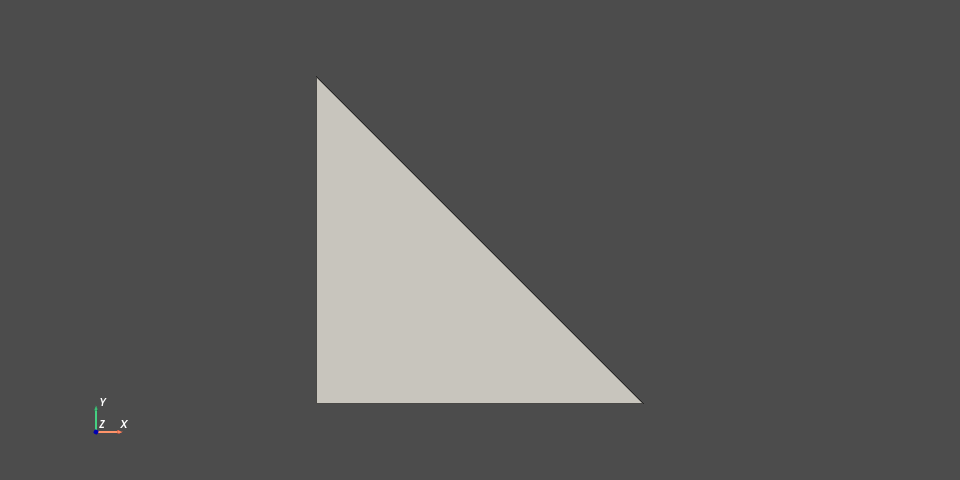

In [10]:
p = plot_mesh(one_tri)
p.show(**show_args)

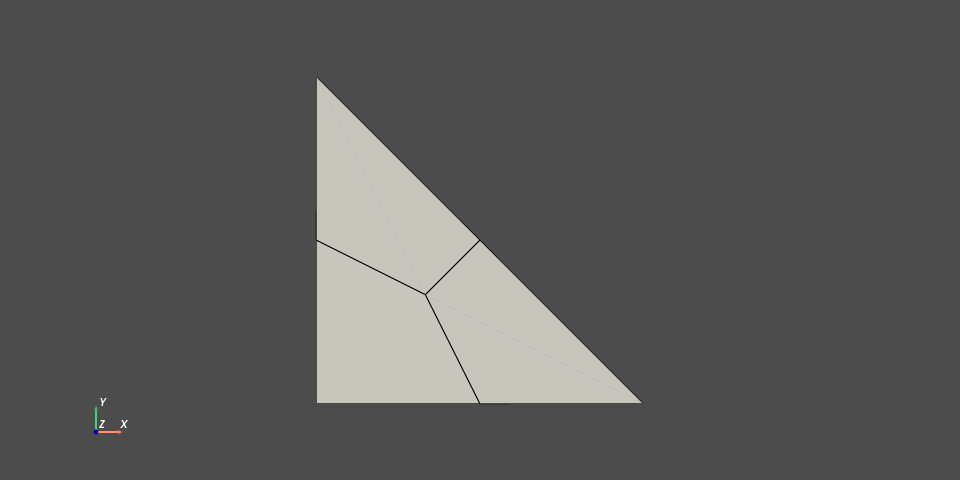

In [11]:
p = plot_mesh(one_tri_div)
p.show(**show_args)

## Single Tetrahedron

In [12]:
one_tet_dict = {'points': np.array([[0., 0., 0.], [1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]),
                'cells': np.array([[0, 1, 2, 3]]), 'cell_geom': 'tetra'}
one_tet = create_dolfinx_mesh(one_tet_dict)
one_tet_div = tetridiv.tet2hex(mesh=one_tet)
if save_tests:
    save_test_case(input_mesh=one_tet_dict, output_mesh=one_tet_div, save_name='one_tet')

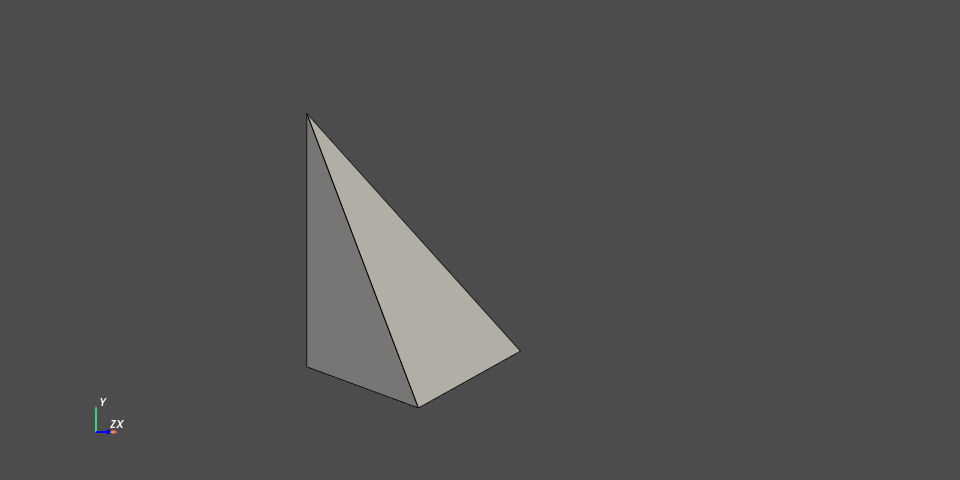

In [13]:
p = plot_mesh(one_tet)
p.camera.azimuth -= 30
p.show(**show_args)

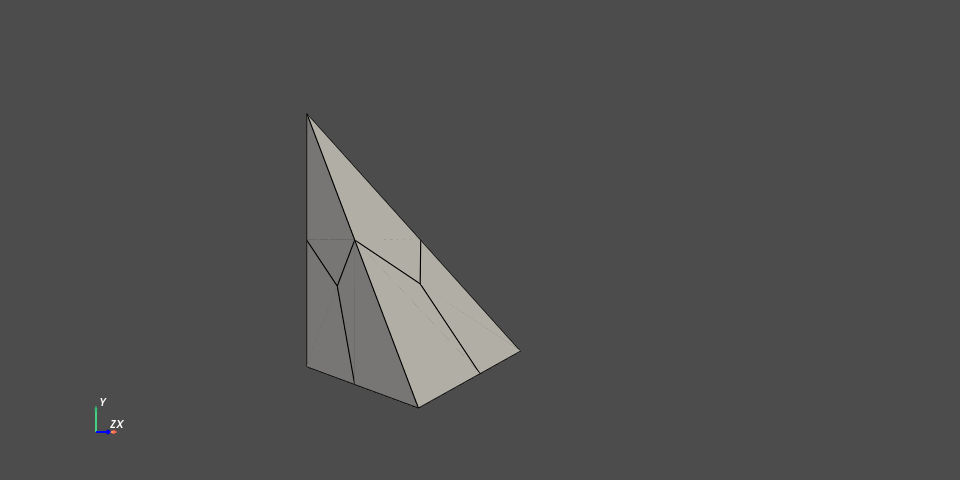

In [14]:
p = plot_mesh(one_tet_div)
p.camera.azimuth -= 30
p.show(**show_args)

# Two Elements

## Two Triangles

In [15]:
two_tri_dict = {'points': np.array([[0., 0.], [1., 0.], [0., 1.], [1.,1.]]),
                'cells': np.array([[0, 1, 2], [1, 2, 3]]), 'cell_geom': 'triangle'}
two_tri = create_dolfinx_mesh(two_tri_dict)
two_tri_div = tetridiv.tri2quad(mesh=two_tri)
if save_tests:
    save_test_case(input_mesh=two_tri_dict, output_mesh=two_tri_div, save_name='two_tri')

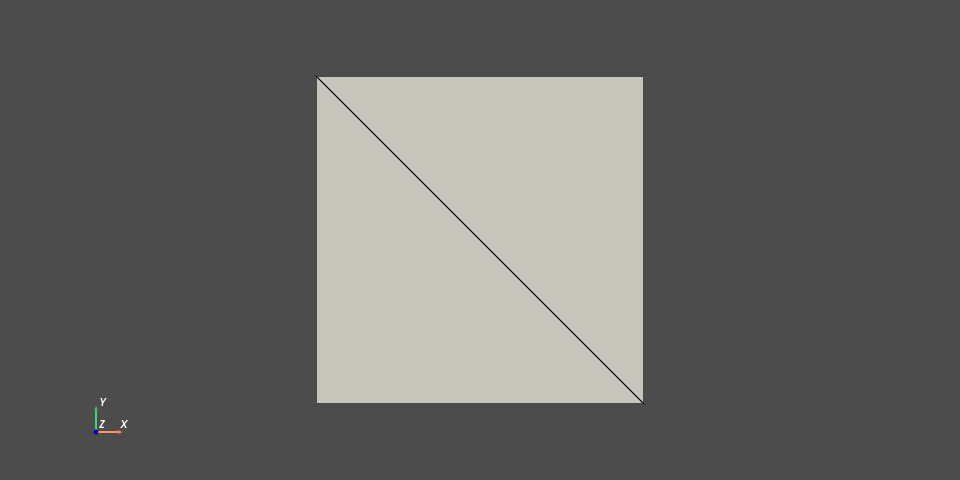

In [16]:
p = plot_mesh(two_tri)
p.show(**show_args)

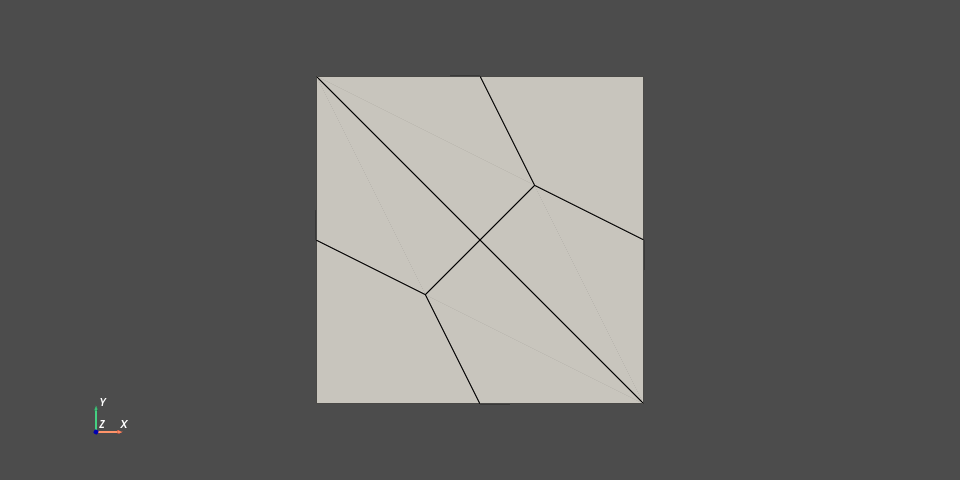

In [17]:
p = plot_mesh(two_tri_div)
p.show(**show_args)

## Two Tetrahedrons

In [18]:
two_tet_dict = {'points':  np.array([[0., 0., 0.], [1., 0., 0.], [0., 1., 0.], [0., 0., 1.], [0., 0., -1.]]),
                'cells': np.array([[0, 1, 2, 3], [0, 1, 2, 4]]), 'cell_geom': 'tetra'} 
two_tet = create_dolfinx_mesh(two_tet_dict)
two_tet_div = tetridiv.tet2hex(mesh=two_tet)
if save_tests:
    save_test_case(input_mesh=two_tet_dict, output_mesh=two_tet_div, save_name='two_tet')

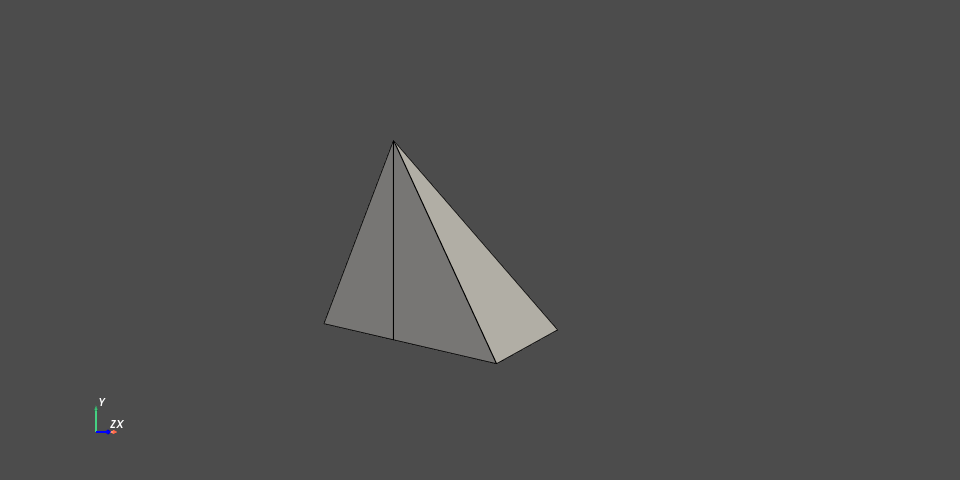

In [19]:
p = plot_mesh(two_tet)
p.camera.azimuth -= 30
p.show(**show_args)

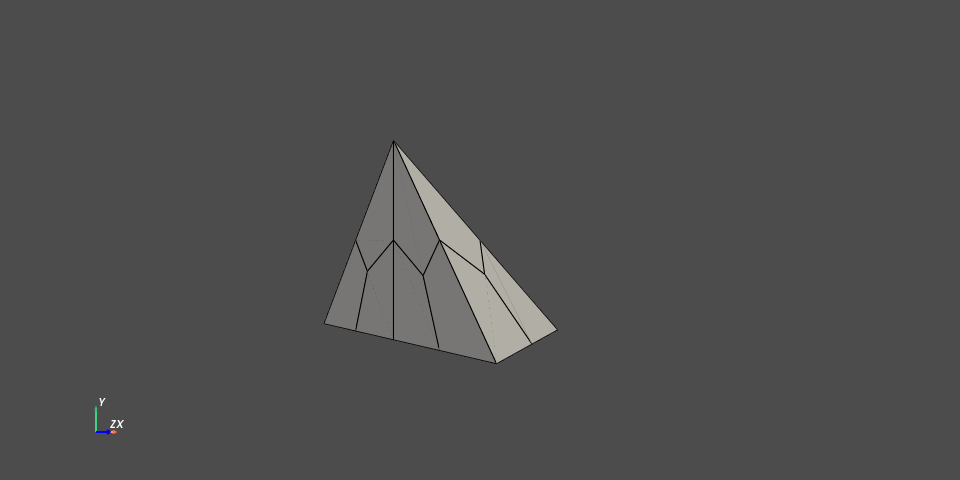

In [20]:
p = plot_mesh(two_tet_div)
p.camera.azimuth -= 30
p.show(**show_args)

# 2d Circular Surface

In [21]:
centre = [0.0, 0.0, 0.0]
radius = 1.0
mesh_size = 0.1
with pygmsh.geo.Geometry() as geom:
    geom.add_circle(centre, radius, mesh_size, num_sections = 4)
    pygmsh_mesh = geom.generate_mesh(dim=2)
    pygmsh.write('circle.msh')
circle = meshio.read("circle.msh")
os.remove("circle.msh")
circle_dict = {'points': circle.points, 'cells': circle.cells_dict['triangle'], 'cell_geom': 'triangle'}
circle = create_dolfinx_mesh(circle_dict)
circle_div = tetridiv.tri2quad(circle)
if save_tests:
    save_test_case(input_mesh=circle_dict, output_mesh=circle_div, save_name='circle')

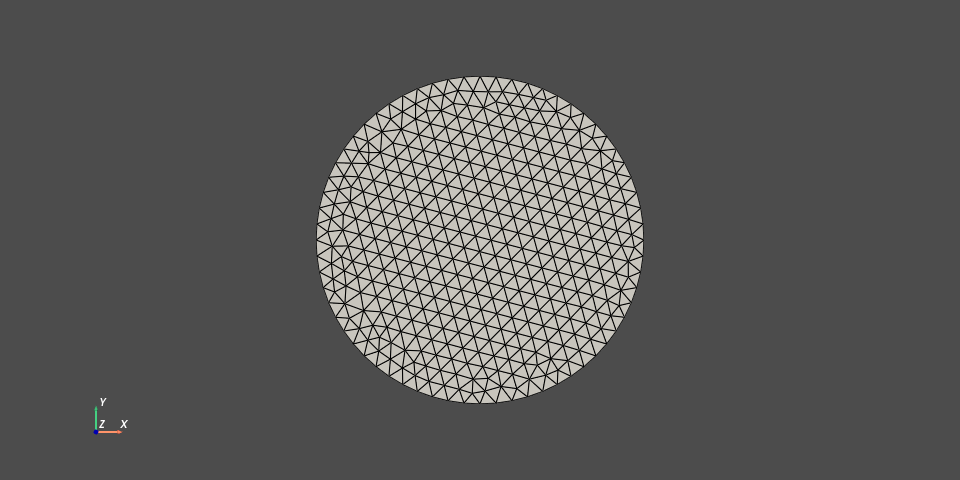

In [22]:
p = plot_mesh(circle)
p.show(**show_args)

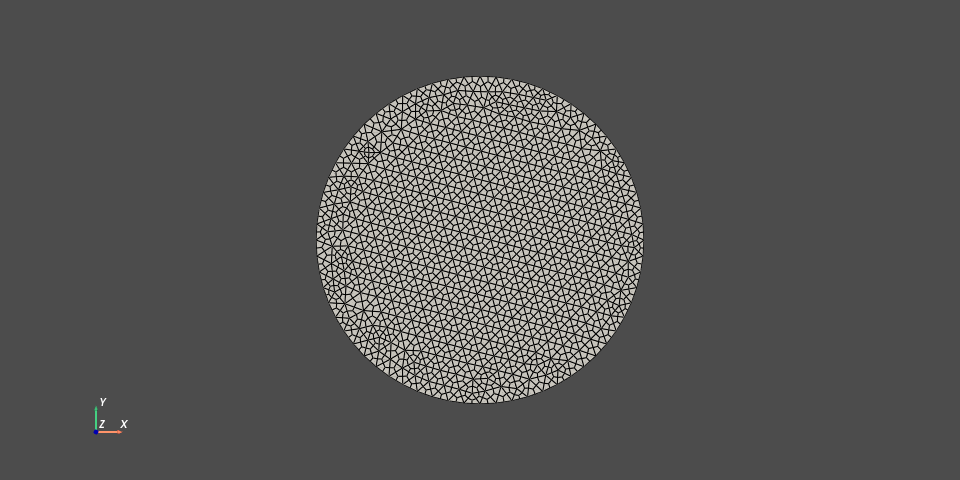

In [23]:
p = plot_mesh(circle_div)
p.show(**show_args)

# 3d Ellipsoidal Surface

In [24]:
centre = [0.0, 0.0, 0.0]
radii = [10.0, 15, 20]
mesh_size = 2
with pygmsh.geo.Geometry() as geom:
    geom.add_ellipsoid(centre, radii, mesh_size, with_volume=False)
    pygmsh_mesh = geom.generate_mesh(dim=2)
    pygmsh.write('ellipsoid.msh')
ellipsoid_surf = meshio.read("ellipsoid.msh")
os.remove("ellipsoid.msh")
ellipsoid_surf_dict = {'points': ellipsoid_surf.points, 
                       'cells': ellipsoid_surf.cells_dict['triangle'], 
                       'cell_geom': 'triangle'}
ellipsoid_surf = create_dolfinx_mesh(ellipsoid_surf_dict)
ellipsoid_surf_div = tetridiv.tri2quad(ellipsoid_surf)
if save_tests:
    save_test_case(input_mesh=ellipsoid_surf_dict, output_mesh=ellipsoid_surf_div, save_name='ellipsurf')

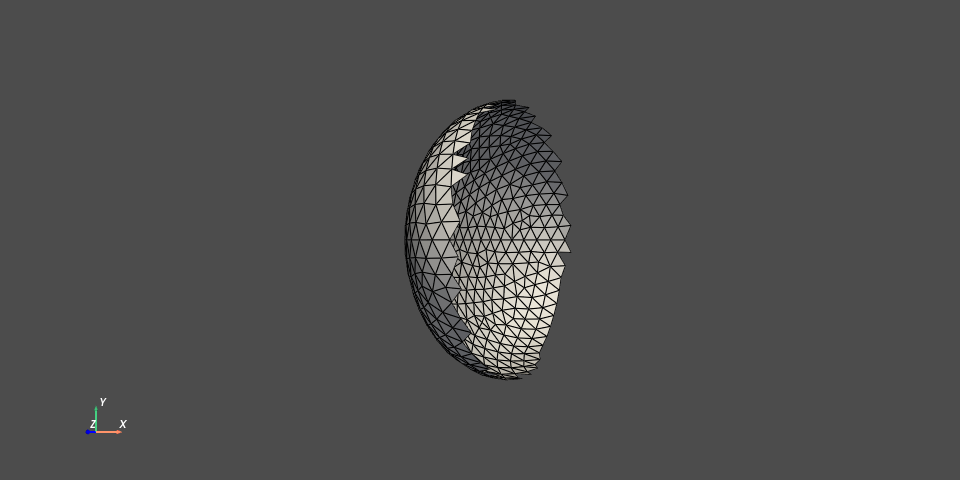

In [25]:
p = plot_mesh(ellipsoid_surf, slice_mesh=True)
p.camera.azimuth += 20
p.show(**show_args)

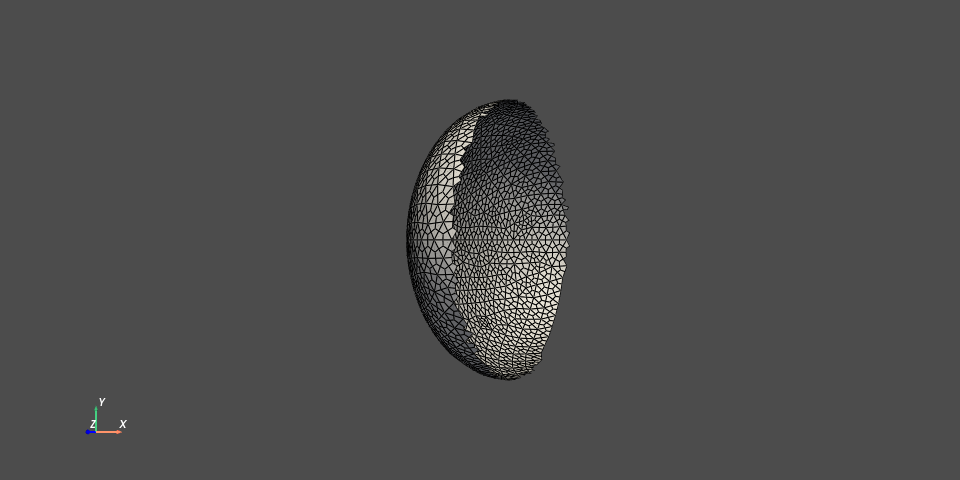

In [26]:
p = plot_mesh(ellipsoid_surf_div, slice_mesh=True)
p.camera.azimuth += 20
p.show(**show_args)

# 3d Volume Tests

In [27]:
centre = [0.0, 0.0, 0.0]
radii = [1.0, 1.5, 2.0]
mesh_size = 0.5
with pygmsh.geo.Geometry() as geom:
    geom.add_ellipsoid(centre, radii, mesh_size, with_volume=True)
    pygmsh_mesh = geom.generate_mesh(dim=3)
    pygmsh.write('ellipsoid.msh')
ellipsoid_vol = meshio.read("ellipsoid.msh")
os.remove("ellipsoid.msh")
ellipsoid_vol_dict = {'points': ellipsoid_vol.points, 
                      'cells': ellipsoid_vol.cells_dict['tetra'], 
                      'cell_geom': 'tetra'}
ellipsoid_vol = create_dolfinx_mesh(ellipsoid_vol_dict)
ellipsoid_vol_div = tetridiv.tet2hex(ellipsoid_vol)
if save_tests:
    save_test_case(input_mesh=ellipsoid_vol_dict, output_mesh=ellipsoid_vol_div, save_name='ellipvol')

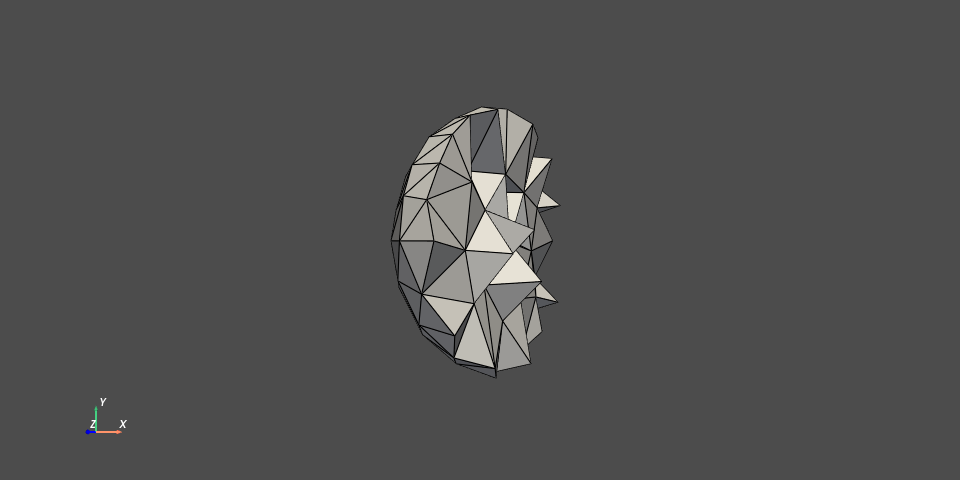

In [28]:
p = plot_mesh(ellipsoid_vol, slice_mesh=True)
p.camera.azimuth += 20
p.show(**show_args)

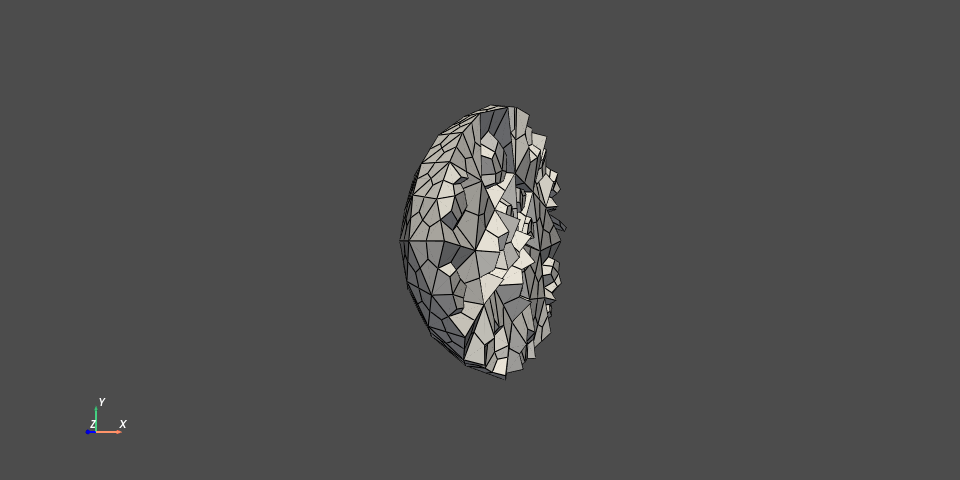

In [29]:
p = plot_mesh(ellipsoid_vol_div, slice_mesh=True)
p.camera.azimuth += 20
p.show(**show_args)